In [1]:
%matplotlib inline


# LINDA nowcasts

This example shows how to compute and plot a deterministic and ensemble LINDA
nowcasts using Swiss radar data.


In [2]:
from datetime import datetime
import warnings

warnings.simplefilter("ignore")

import matplotlib.pyplot as plt

from pysteps import io, rcparams
from pysteps.motion.lucaskanade import dense_lucaskanade
from pysteps.nowcasts import linda, sprog, steps
from pysteps.utils import conversion, dimension, transformation
from pysteps.visualization import plot_precip_field

Pysteps configuration file found at: /home/runner/.pysteps/pystepsrc



## Read the input rain rate fields



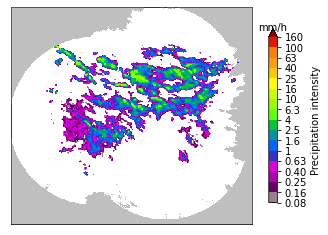

In [3]:
date = datetime.strptime("201701311200", "%Y%m%d%H%M")
data_source = "mch"

# Read the data source information from rcparams
datasource_params = rcparams.data_sources[data_source]

# Find the radar files in the archive
fns = io.find_by_date(
    date,
    datasource_params["root_path"],
    datasource_params["path_fmt"],
    datasource_params["fn_pattern"],
    datasource_params["fn_ext"],
    datasource_params["timestep"],
    num_prev_files=2,
)

# Read the data from the archive
importer = io.get_method(datasource_params["importer"], "importer")
reflectivity, _, metadata = io.read_timeseries(
    fns, importer, **datasource_params["importer_kwargs"]
)

# Convert reflectivity to rain rate
rainrate, metadata = conversion.to_rainrate(reflectivity, metadata)

# Upscale data to 2 km to reduce computation time
rainrate, metadata = dimension.aggregate_fields_space(rainrate, metadata, 2000)

# Plot the most recent rain rate field
plt.figure()
plot_precip_field(rainrate[-1, :, :])
plt.show()

## Estimate the advection field



In [4]:
# The advection field is estimated using the Lucas-Kanade optical flow
advection = dense_lucaskanade(rainrate, verbose=True)

Computing the motion field with the Lucas-Kanade method.
--- 5 outliers detected ---
--- LK found 176 sparse vectors ---
--- 63 samples left after declustering ---
--- total time: 0.54 seconds ---


## Deterministic nowcast



Computing LINDA nowcast
-----------------------

Inputs
------
dimensions:           320x355
number of time steps: 3

Methods
-------
nowcast type:         deterministic
feature detector:     blob
extrapolator:         semilagrangian
kernel type:          anisotropic

Parameters
----------
number of time steps:       6
ARI model order:            1
localization window radius: 64.0

Detecting features... found 15 blobs in 0.95 seconds.
Transforming to Lagrangian coordinates... 0.10 seconds.
Estimating the first convolution kernel... 8.94 seconds.
Estimating the ARI(p,1) parameters... 0.16 seconds.
Estimating the second convolution kernel... 8.12 seconds.
Computing nowcast for time step 1... 0.39 seconds.
Computing nowcast for time step 2... 0.39 seconds.
Computing nowcast for time step 3... 0.40 seconds.
Computing nowcast for time step 4... 0.40 seconds.
Computing nowcast for time step 5... 0.43 seconds.
Computing nowcast for time step 6... 0.42 seconds.
Computing S-PROG nowcast:
------

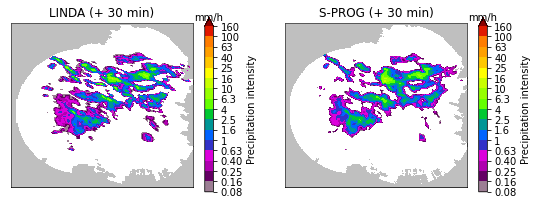

In [5]:
# Compute 30-minute LINDA nowcast with 8 parallel workers
# Restrict the number of features to 15 to reduce computation time
nowcast_linda = linda.forecast(
    rainrate,
    advection,
    6,
    max_num_features=15,
    add_perturbations=False,
    num_workers=8,
    measure_time=True,
)[0]

# Compute S-PROG nowcast for comparison
rainrate_db, _ = transformation.dB_transform(
    rainrate, metadata, threshold=0.1, zerovalue=-15.0
)
nowcast_sprog = sprog.forecast(
    rainrate_db[-3:, :, :],
    advection,
    6,
    n_cascade_levels=6,
    R_thr=-10.0,
)

# Convert reflectivity nowcast to rain rate
nowcast_sprog = transformation.dB_transform(
    nowcast_sprog, threshold=-10.0, inverse=True
)[0]

# Plot the nowcasts
fig = plt.figure(figsize=(9, 4))
ax = fig.add_subplot(1, 2, 1)
plot_precip_field(
    nowcast_linda[-1, :, :],
    title="LINDA (+ 30 min)",
)

ax = fig.add_subplot(1, 2, 2)
plot_precip_field(
    nowcast_sprog[-1, :, :],
    title="S-PROG (+ 30 min)",
)

plt.show()

The above figure shows that the filtering scheme implemented in LINDA preserves
small-scale and band-shaped features better than S-PROG. This is because the
former uses a localized elliptical convolution kernel instead of the
cascade-based autoregressive process, where the parameters are estimated over
the whole domain.



## Probabilistic nowcast



Computing LINDA nowcast
-----------------------

Inputs
------
dimensions:           320x355
number of time steps: 3

Methods
-------
nowcast type:         ensemble
feature detector:     blob
extrapolator:         semilagrangian
kernel type:          anisotropic

Parameters
----------
number of time steps:       6
ARI model order:            1
localization window radius: 64.0
error dist. window radius:  48.0
error ACF window radius:    80.0
ensemble size:              40
parallel workers:           8
seed:                       None

Detecting features... found 15 blobs in 0.93 seconds.
Transforming to Lagrangian coordinates... 0.08 seconds.
Estimating the first convolution kernel... 8.95 seconds.
Estimating the ARI(p,1) parameters... 0.15 seconds.
Estimating the second convolution kernel... 8.08 seconds.
Estimating forecast errors... 0.62 seconds.
Estimating perturbation parameters... 39.31 seconds.
Computing STEPS nowcast:
------------------------

Inputs:
-------
input dimensions: 3

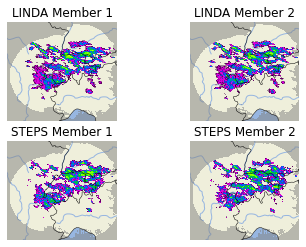

In [6]:
# Compute 30-minute LINDA nowcast ensemble with 40 members and 8 parallel workers
nowcast_linda = linda.forecast(
    rainrate,
    advection,
    6,
    max_num_features=15,
    add_perturbations=True,
    num_ens_members=40,
    num_workers=8,
    measure_time=True,
)[0]

# Compute 40-member STEPS nowcast for comparison
nowcast_steps = steps.forecast(
    rainrate_db[-3:, :, :],
    advection,
    6,
    40,
    n_cascade_levels=6,
    R_thr=-10.0,
    mask_method="incremental",
    kmperpixel=2.0,
    timestep=datasource_params["timestep"],
    vel_pert_method=None,
)

# Convert reflectivity nowcast to rain rate
nowcast_steps = transformation.dB_transform(
    nowcast_steps, threshold=-10.0, inverse=True
)[0]

# Plot two ensemble members of both nowcasts
fig = plt.figure()
for i in range(2):
    ax = fig.add_subplot(2, 2, i + 1)
    ax = plot_precip_field(
        nowcast_linda[i, -1, :, :], geodata=metadata, colorbar=False, axis="off"
    )
    ax.set_title(f"LINDA Member {i+1}")

for i in range(2):
    ax = fig.add_subplot(2, 2, 3 + i)
    ax = plot_precip_field(
        nowcast_steps[i, -1, :, :], geodata=metadata, colorbar=False, axis="off"
    )
    ax.set_title(f"STEPS Member {i+1}")

The above figure shows the main difference between LINDA and STEPS. In
addition to the convolution kernel, another improvement in LINDA is a
localized perturbation generator using the short-space Fourier transform
(SSFT) and a spatially variable marginal distribution. As a result, the
LINDA ensemble members preserve the anisotropic and small-scale structures
considerably better than STEPS.



In [7]:
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>